In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import pandas as pd
#import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve

/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## Zadanie 1 [3 pkt]

1. Powyższy model ma istotnie wyższy recall niż precision. 

Zdefiniujmy jako model probabilistyczny model, który zwraca p($\hat{y}$ | y). Obiekt LogisticRegression zwraca tą wartość funkcją ``predict_proba``

1. Każdy model probabilistyczny można użyć do stworzenia klasyfikora, która może mieć precision 100% lub recall 100% trywialnie, jak? 

2. Krzywa precision/recall jest obliczana licząc precision oraz recall modelu probabilistycznego dla różnych wartości precision. Zarysuj wykres precision/recall dla modelu powyżej.

Powinno wyjść:

<img src="figures/L7/prec_recall.png">

Recall 100% - always true.
Precision 100% - if probability = 1, then true. 


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


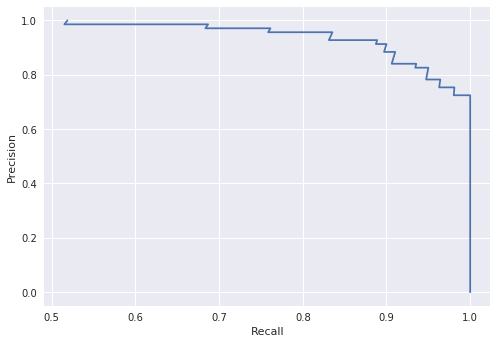

In [2]:
data = pd.read_csv("data/L7/breast_cancer_transformer.csv")
data.drop("Unnamed: 32",axis=1,inplace=True)
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0})
prediction_var = ['texture_mean','perimeter_mean','smoothness_mean','compactness_mean','symmetry_mean']
train, test = train_test_split(data, test_size = 0.3)# in this our main data is splitted into train and test
train_X = train[prediction_var][0:100]
train_y=train.diagnosis[0:100]
test_X= test[prediction_var] 
test_y =test.diagnosis  
model = LogisticRegression(C=50)
model.fit(train_X,train_y)


scores = model.predict_proba(test_X)[:, 1]
precision, recall, thresholds = precision_recall_curve(test_y, scores)

plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Zadanie 2 [3 pkt]

Założmy, że $C_{FP}$ = 1 i $C_{FN}$ = 10, co odpowiada sytuacji w której nie przejmujemy się postawieniem fałszywej pozytywnej diagnozy.

Według http://web.cs.iastate.edu/~honavar/elkan.pdf wystarczy w takim wypadku dodać przykładom odpowiednią wage.

a) Przetestuj pare wag klasy pozytywnej przez podanie argumentu class_weight do LogisticRegression. Dla każdej wartości wagi narysuj dokładność (accuracy) oraz wynik metryki FN_aversive. Powinno wyjść:

<img src="figures/L7/fn_aversive.png">

b) Równoważnym sposobem tworzenia "cost-sensitive" klasyfikatora z modelu probabilistycznego jest zmiana progu (patrz Zadanie 1). Znajdź taki próg, aby wynik klasyfikatora z tym progiem był równoważny argumentowi class_weight, który daje w punkcie a) najlepszy wynik.

Podpowiedź: Jeśli 2 sprawia problem, przejrzyj załączoną publikację


Uwagi/uściślenia:

* Proszę podać klasę wagi *pozytywnej* nie negatywnej 
* Wynik a) i b) w praktyce powinien być tylko w przybliżeniu ten sam. 
* Rysunek używa wartości wag odpowiednio [0.5, 1, 5, 10, 100]

/usr/lib/python3.6/site-packages/pandas/computation/expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


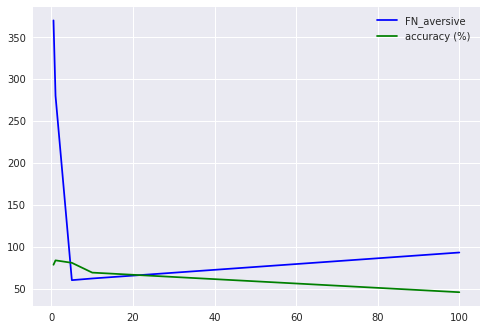

In [3]:
def FN_aversive(y_true, y_pred):
    FN = sum((y_true == 1) * (y_pred != y_true))
    FP = sum((y_true == 0) * (y_pred != y_true))
    return 10 * FN + FP

def acc_fn(weights, C=2):
    list_acc = []
    list_fn = []

    for w in weights:
        model = LogisticRegression(C = C, class_weight = {0: 1, 1: w})
        model.fit(train_X,train_y)
        pred = model.predict(test_X)
        list_acc.append(accuracy_score(pred, test_y)*100)
        list_fn.append(FN_aversive(test_y, pred))
    return list_acc, list_fn

weights =  [0.5, 1, 5, 10, 100]
list_acc, list_fn = acc_fn(weights)

plt.plot(weights, list_fn, c = "b", label='FN_aversive')
plt.plot(weights, list_acc, c = "g", label='accuracy (%)')
plt.legend()
plt.show()

In [4]:
C = range(1, 100, 1)
acc = 0
ci = 0
for c in C:
    model = LogisticRegression(C=c)
    model.fit(train_X,train_y)
    pred = model.predict(test_X)
    tmp = accuracy_score(pred, test_y)*100
    if tmp > acc:
        acc = tmp
        fn = FN_aversive(pred, test_y)
        ci = c
print("C = ", ci)
print("Accuracy = ", acc)
print("FN_aversive = ", fn)

C =  76
Accuracy =  90.6432748538
FN_aversive =  34


/usr/lib/python3.6/site-packages/pandas/computation/expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


## Zadanie 3 [3 pkt]

Naive Bayes jest często stosowany do problemów klasyfikacyjnych na tekście. W tym zadaniu zajmiemy się klasyfikacją SPAMU. Na wejściu zadany jest test wiadomości e-mail, etykietą jest 0 (prawdziwa wiadomość, "HAM") lub 1 (SPAM).

Podstawowym problemem jest sposób reprezentacji tekstu. Podobnie jak w przypadku rozważanych funkcji bazowych na wcześniejszych zajęciach, modele wymagają stałowymiarowego wektoru. Proszę użyć klasy CountVectorizer z sklearn w celu przekształcenia wiadomości do reprezentacji wektorowej.

    Zastosuj transformację tekstu do reprezentacji bag of words
    Naucz model Naive Bayes (MultinomialNB) przewidywać SPAM
    Pokaż problem "double counting" w modelu Naive Bayes.


In [5]:
messages = pd.read_csv('./data/L7/smsspamcollection/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])

In [6]:
messages['length'] = messages['message'].map(lambda text: len(text))

In [7]:
vectorizer = CountVectorizer(analyzer='word')
messages_bow = vectorizer.fit_transform(messages['message'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5574, 8713)
number of non-zeros: 74169
sparsity: 0.15%


In [8]:
spam_detector = MultinomialNB()
X = messages_bow
y = messages['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
spam_detector.fit(X_train, y_train)
y_pred = spam_detector.predict(X_test)

In [9]:
print('accuracy', metrics.accuracy_score(y_test, y_pred))
print('confusion matrix\n', metrics.confusion_matrix(y_test, y_pred))

accuracy 0.98027495517
confusion matrix
 [[1412   19]
 [  14  228]]
